#Demographic filtering

##Demographic filtering is a technique used in recommender technique which recommends movies taking into consideration the general popularity of a movie.Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.(But that's the best u can do when u know nothing in specific about the user,this is typically the case with new subscribers)
##So,first lets go through the aspects of demographic filtering 

###![](https://makesmarttv.net/wp-content/uploads/2014/10/netflix_more_movies.jpg)

So,lets get started we will try doing something like the NETFLIX demographic filtering shown above

We would try recommending the top 10 highly rated films,top 10 most popular films etc.

Followed by more specific recommendations like top 10 of each genre(comedy,action,children&family movies etc.),followed by 5 best movies of popular actors

This doesn't involve any machine learning(though ML techniques would be extensively used in content-based & collaborative filtering) but is mainly about capitalizing on the critical stats from the TMDB ratings data

Thus,demographic filtering is about giving crude recommendation knowing nothing about the viewer(which is the case for most new subscribers to NETFLIX or other streaming platforms)





##Importing libraries and a peek into the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
movies=pd.read_csv("/content/drive/MyDrive/movies_data/tmdb_5000_movies.csv/tmdb_5000_movies.csv")
credits=pd.read_csv("/content/drive/MyDrive/movies_data/tmdb_5000_credits.csv/tmdb_5000_credits.csv")
print(movies.shape,credits.shape)

(4803, 20) (4803, 4)


In [ ]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Lets make note of the key features in both datsets:

1)genres

2)cast

3)popularity

2)average rating

3)number of votes

##Data-preprocessing

Lets make the things simple by discarding all other features and merging both the datasets

###Merging the datsets

In [ ]:
#rename movie-id to id so as to merge both on the id
credits.rename(columns={"movie_id":"id"},inplace=True)
print(credits.columns)

Index(['id', 'title', 'cast', 'crew'], dtype='object')


In [ ]:
movies= movies.merge(credits,on='id')
print(movies.shape)
movies.columns

(4803, 23)


Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')

Having merged both datasets let's discard the less useful features

In [ ]:
relevant_cols=["id","title_x","genres","popularity","vote_average","vote_count","cast"]
movies=movies.loc[:,relevant_cols]
movies.shape

(4803, 7)

In [ ]:
movies.rename(columns={"title_x":"title","vote_average":"rating"},inplace=True)
movies.columns

Index(['id', 'title', 'genres', 'popularity', 'rating', 'vote_count', 'cast'], dtype='object')

###The data in genres and cast columns are strings,let's attempt to understand them and process these data into lists of genres and actors respectively

In [ ]:
#Lets pick row 100 and analyse its genres & cast columns
row_id=100
print(movies.loc[row_id,"title"])
print(movies.loc[row_id,"genres"],'\n',movies.loc[row_id,"cast"])

The Curious Case of Benjamin Button
[{"id": 14, "name": "Fantasy"}, {"id": 18, "name": "Drama"}, {"id": 53, "name": "Thriller"}, {"id": 9648, "name": "Mystery"}, {"id": 10749, "name": "Romance"}] 
 [{"cast_id": 4, "character": "Daisy", "credit_id": "52fe43e2c3a36847f807632b", "gender": 1, "id": 112, "name": "Cate Blanchett", "order": 0}, {"cast_id": 5, "character": "Benjamin Button", "credit_id": "52fe43e2c3a36847f807632f", "gender": 2, "id": 287, "name": "Brad Pitt", "order": 1}, {"cast_id": 6, "character": "Elizabeth Abbott", "credit_id": "52fe43e2c3a36847f8076333", "gender": 1, "id": 3063, "name": "Tilda Swinton", "order": 2}, {"cast_id": 10, "character": "Caroline", "credit_id": "52fe43e2c3a36847f8076343", "gender": 1, "id": 15887, "name": "Julia Ormond", "order": 3}, {"cast_id": 7, "character": "Daisy Age 7", "credit_id": "52fe43e2c3a36847f8076337", "gender": 1, "id": 18050, "name": "Elle Fanning", "order": 4}, {"cast_id": 183, "character": "Daisy Age 10", "credit_id": "56ec883a92

In [ ]:
#The genre and cast are string type first lets make functions to convert them to dictionaries
def process_genre(s):
  id_str=s.split(", ")[0]
  genre_str=s.split(", ")[-1]
  genre={}
  genre["id"]=int(id_str.split(':')[-1])
  genre["name"]=(genre_str.split(':')[-1])[2:-1]
  return genre

def get_genres(s):
  if(len(s)<5):
    return {}
  genres=s.split("}, {")
  genres[0]=genres[0][2:]
  genres[-1]=genres[-1][:-2]
  genre_list=[]
  for genre in genres:
    genre_list.append(process_genre(genre))
  return genre_list

def process_actor(s):
  id_str=s.split(", ")[0]
  actor_str=s.split(", ")[-2]
  actor={}
  actor["id"]=int(id_str.split(':')[-1])
  actor["name"]=(actor_str.split(':')[-1])[2:-1]
  return actor

def get_cast(s):
  if(len(s)<5):
    return {}
  cast=s.split("}, {")
  cast[0]=cast[0][2:]
  cast[-1]=cast[-1][:-2]
  cast_list=[]
  for actor in cast:
    cast_list.append(process_actor(actor))
  return cast_list

In [ ]:
#Lets test these functions
import random
row_id=int(random.random()*movies.shape[0]//1)      #choose a random movie
print(movies.loc[row_id,"title"])
Genres=get_genres(movies.loc[row_id,"genres"])
print("GENRES")
for idx,genre in enumerate(Genres):
  print((idx+1),':',genre)
Cast=get_cast(movies.loc[row_id,"cast"])
print("CAST")
for idx,actor in enumerate(Cast):
  print((idx+1),':',actor)

Mr. Smith Goes to Washington
GENRES
1 : {'id': 35, 'name': 'Comedy'}
2 : {'id': 18, 'name': 'Drama'}
CAST
1 : {'id': 9, 'name': 'James Stewart'}
2 : {'id': 8, 'name': 'Jean Arthur'}
3 : {'id': 10, 'name': 'Claude Rains'}
4 : {'id': 11, 'name': 'Edward Arnold'}
5 : {'id': 12, 'name': 'Guy Kibbee'}
6 : {'id': 13, 'name': 'Thomas Mitchell'}
7 : {'id': 14, 'name': 'Eugene Pallette'}
8 : {'id': 15, 'name': 'Beulah Bondi'}
9 : {'id': 258, 'name': 'Colin James Mackey'}
10 : {'id': 17, 'name': 'Harry Carey'}
11 : {'id': 55, 'name': 'H.B. Warner'}
12 : {'id': 20, 'name': 'Grant Mitchell'}
13 : {'id': 22, 'name': 'Pierre Watkin'}
14 : {'id': 21, 'name': 'Porter Hall'}
15 : {'id': 56, 'name': 'Astrid Allwyn'}
16 : {'id': 19, 'name': 'Ruth Donnelly'}
17 : {'id': 23, 'name': 'Charles Lane'}
18 : {'id': 24, 'name': 'William Demarest'}
19 : {'id': 25, 'name': 'Dick Elliott'}
20 : {'id': 198, 'name': 'Russell Simpson'}
21 : {'id': 27, 'name': 'Delmar Watson'}
22 : {'id': 39, 'name': 'John Russell'}
23

Seems to be working fine

##Data visualization

Text(0, 0.5, 'Vote count')

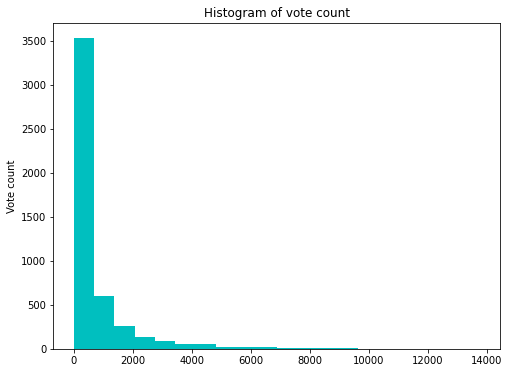

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(movies['vote_count'],bins=20,color='c')
plt.title("Histogram of vote count")
plt.ylabel("Vote count")

Thus,most of the movies have less than 1000 rating votes

Text(0.5, 1.0, 'popularity v/s ratings')

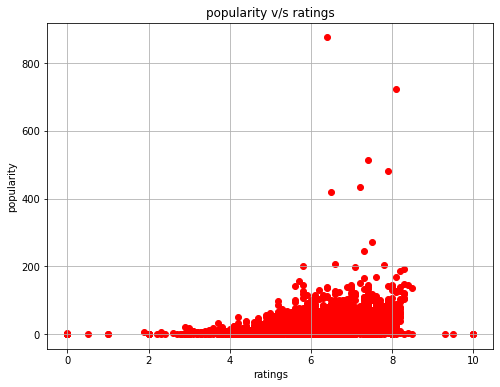

In [ ]:
plt.figure(figsize=(8,6))
plt.grid(2)
plt.scatter(movies["rating"],movies["popularity"],c='r')
plt.xlabel("ratings")
plt.ylabel("popularity")
plt.title("popularity v/s ratings")

There is a positive correlation between ratings and popularity

##Demographic filtering

###Top 10 most popular movies

In [ ]:
#Lets look at movies with vote_count greater than the 90th percentile or quantile
#As others aren't really popular and their popularity score is most likely subject to high variance
threshold_vote= movies['vote_count'].quantile(0.9)
print(threshold_vote)
#Basically the 90th quantile of vote_count 

1838.4000000000015


Now lets look at the top 10 movies with highest popularity among movies with vote_count greater than the threshold

In [ ]:
popular_picks=list(movies[movies['vote_count']>threshold_vote].nlargest(10,'popularity').loc[:,'title'])
movies[movies['vote_count']>threshold_vote].nlargest(10,'popularity')

,id,title,genres,popularity,rating,vote_count,cast
546,211672,Minions,"[{""id"": 10751, ""name"": ""Family""}, {""id"": 16, ""...",875.581305,6.4,4571,"[{""cast_id"": 22, ""character"": ""Scarlet Overkil..."
95,157336,Interstellar,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",724.247784,8.1,10867,"[{""cast_id"": 9, ""character"": ""Joseph Cooper"", ..."
788,293660,Deadpool,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",514.569956,7.4,10995,"[{""cast_id"": 99, ""character"": ""Wade Wilson / D..."
94,118340,Guardians of the Galaxy,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",481.098624,7.9,9742,"[{""cast_id"": 1, ""character"": ""Peter Quill / St..."
127,76341,Mad Max: Fury Road,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",434.278564,7.2,9427,"[{""cast_id"": 2, ""character"": ""Max Rockatansky""..."
28,135397,Jurassic World,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",418.708552,6.5,8662,"[{""cast_id"": 10, ""character"": ""Owen Grady"", ""c..."
199,22,Pirates of the Caribbean: The Curse of the Bla...,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",271.972889,7.5,6985,"[{""cast_id"": 12, ""character"": ""Captain Jack Sp..."
82,119450,Dawn of the Planet of the Apes,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...",243.791743,7.3,4410,"[{""cast_id"": 8, ""character"": ""Caesar"", ""credit..."
200,131631,The Hunger Games: Mockingjay - Part 1,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...",206.227151,6.6,5584,"[{""cast_id"": 2, ""character"": ""Katniss Everdeen..."
88,177572,Big Hero 6,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 10751...",203.734590,7.8,6135,"[{""cast_id"": 23, ""character"": ""Baymax (voice)""..."


###Top 10 highest rated movies

Now lets look at the top 10 movies with highest rating among movies with vote_count greater than the threshold

In [ ]:
top_rated=list(movies[movies['vote_count']>threshold_vote].nlargest(10,'rating').loc[:,'title'])
movies[movies['vote_count']>threshold_vote].nlargest(10,'rating')

,id,title,genres,popularity,rating,vote_count,cast
1881,278,The Shawshank Redemption,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",136.747729,8.5,8205,"[{""cast_id"": 3, ""character"": ""Andy Dufresne"", ..."
3337,238,The Godfather,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",143.659698,8.4,5893,"[{""cast_id"": 5, ""character"": ""Don Vito Corleon..."
662,550,Fight Club,"[{""id"": 18, ""name"": ""Drama""}]",146.757391,8.3,9413,"[{""cast_id"": 4, ""character"": ""The Narrator"", ""..."
1818,424,Schindler's List,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 36, ""name...",104.469351,8.3,4329,"[{""cast_id"": 14, ""character"": ""Oskar Schindler..."
2294,129,Spirited Away,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 12, ""na...",118.968562,8.3,3840,"[{""cast_id"": 3, ""character"": ""Chihiro (voice)""..."
2731,240,The Godfather: Part II,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",105.792936,8.3,3338,"[{""cast_id"": 8, ""character"": ""Don Michael Corl..."
3232,680,Pulp Fiction,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 80, ""n...",121.463076,8.3,8428,"[{""cast_id"": 2, ""character"": ""Vincent Vega"", ""..."
3865,244786,Whiplash,"[{""id"": 18, ""name"": ""Drama""}]",192.528841,8.3,4254,"[{""cast_id"": 5, ""character"": ""Andrew Neimann"",..."
65,155,The Dark Knight,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",187.322927,8.2,12002,"[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""..."
690,497,The Green Mile,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 18, ""na...",103.698022,8.2,4048,"[{""cast_id"": 4, ""character"": ""Paul Edgecomb"", ..."


###Top movies in different genres

In [ ]:
def check_genre(top_genre,genres):
  for genre in genres:
    if(genre["name"]==top_genre):
      return True
  return False

top_genre={}
#Let's look at common genres & let's recommend 3 movies for each genres
allGenres={}
for row_id in range(movies.shape[0]):
  genres=get_genres(movies.loc[row_id,"genres"])
  for genre in genres:
    if genre["name"] in allGenres.keys():
      allGenres[genre["name"]]+=1
    else:
      allGenres[genre["name"]]=1

#If say there are over 10% movies of a particluar genre let's call that a common genre
#for each common genre let's choose top 3 based on the ratings

for key,val in allGenres.items():
  if(val>movies.shape[0]/10):
    top_genre[key]=[]

for genre in top_genre.keys():
  top_in_genre=[]
  for row_id in range(movies.shape[0]):
    if(check_genre(genre,get_genres(movies.loc[row_id,"genres"]))):
      if(len(top_in_genre)<3):
        top_in_genre.append((row_id,movies.loc[row_id,"rating"]))
      else:
        if(top_in_genre[-1][1]<movies.loc[row_id,"rating"]):
          top_in_genre.pop()
          top_in_genre.append((row_id,movies.loc[row_id,"rating"]))
      sorted(top_in_genre,key=lambda x:x[1],reverse=True)
  top_genre[genre].append(movies.loc[top_in_genre[2][0],"title"])
  top_genre[genre].append(movies.loc[top_in_genre[1][0],"title"])
  top_genre[genre].append(movies.loc[top_in_genre[0][0],"title"])

Lets visualize the number of movies in each genre

Text(0.5, 1.0, 'Number of movies in each genre')

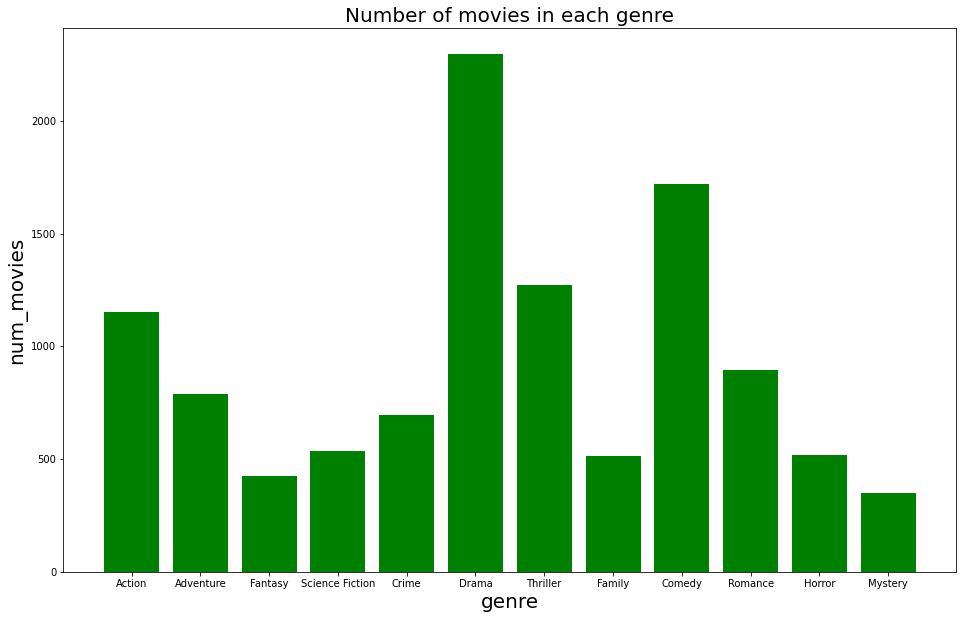

In [ ]:
X=[]
y=[]
for genre,n_movies in allGenres.items():
  if(n_movies>300):
    X.append(genre)
    y.append(n_movies)
plt.figure(figsize=(16,10))
plt.bar(X,y,color='green')
plt.xlabel("genre",fontsize=20)
plt.ylabel("num_movies",fontsize=20)
plt.title("Number of movies in each genre",fontsize=20)

Most of the movies are drama,comedy and all others have substantial number of movies

###Top movies of popular actors

In [ ]:
def check_actor(top_actor,cast):
  for actor in cast:
    if(actor["name"]==top_actor):
      return True
  return False

top_actors={}
#Let's look at 10 top actors(based on number of movies they were a part of) & let's recommend 2 movies for each actor
allActors={}
for row_id in range(movies.shape[0]):
  cast=get_cast(movies.loc[row_id,"cast"])
  for actor in cast:
    if actor["name"] in allActors.keys():
      allActors[actor["name"]]+=1
    else:
      allActors[actor["name"]]=1

allActors.pop('.')    #remove all movies without caste
top_actors_list=[i[0] for i in sorted(allActors.items(),key=lambda x:x[1],reverse=True)[:10]]

for actor in top_actors_list:
  top_actors[actor]=[]

for actor in top_actors.keys():
  top_in_actor=[]
  for row_id in range(movies.shape[0]):
    if(check_actor(actor,get_cast(movies.loc[row_id,"cast"]))):
      if(len(top_in_actor)<3):
        top_in_actor.append((row_id,movies.loc[row_id,"rating"]))
      else:
        if(top_in_actor[-1][1]<movies.loc[row_id,"rating"]):
          top_in_actor.pop()
          top_in_actor.append((row_id,movies.loc[row_id,"rating"]))
      sorted(top_in_actor,key=lambda x:x[1],reverse=True)
  top_actors[actor].append(movies.loc[top_in_actor[1][0],"title"])
  top_actors[actor].append(movies.loc[top_in_actor[0][0],"title"])

##Final demographic recommendations

In [ ]:
print("***POPULAR PICKS***")
for idx,movie in enumerate(popular_picks):
  print(idx+1,movie)
print('\n',"****TOP RATED****")
for idx,movie in enumerate(top_rated):
  print(idx+1,movie)
print('\n',"**BEST ACROSS GENRES**")
for genre,movies in top_genre.items():
  print("------>",genre)
  for idx,movie in enumerate(movies):
    print(idx+1,movie)
print('\n',"**MOVIES OF TOP ACTORS**")
for actor,movies in top_actors.items():
  print("------>",actor)
  for idx,movie in enumerate(movies):
    print(idx+1,movie)

***POPULAR PICKS***
1 Minions
2 Interstellar
3 Deadpool
4 Guardians of the Galaxy
5 Mad Max: Fury Road
6 Jurassic World
7 Pirates of the Caribbean: The Curse of the Black Pearl
8 Dawn of the Planet of the Apes
9 The Hunger Games: Mockingjay - Part 1
10 Big Hero 6

 ****TOP RATED****
1 The Shawshank Redemption
2 The Godfather
3 Fight Club
4 Schindler's List
5 Spirited Away
6 The Godfather: Part II
7 Pulp Fiction
8 Whiplash
9 The Dark Knight
10 The Green Mile

 **BEST ACROSS GENRES**
------> Action
1 One Man's Hero
2 Pirates of the Caribbean: At World's End
3 Avatar
------> Adventure
1 The Prisoner of Zenda
2 Pirates of the Caribbean: At World's End
3 Avatar
------> Science Fiction
1 The Empire Strikes Back
2 John Carter
3 Avatar
------> Crime
1 The Shawshank Redemption
2 The Dark Knight Rises
3 Spectre
------> Drama
1 Dancer, Texas Pop. 81
2 King Kong
3 The Dark Knight Rises
------> Thriller
1 Pulp Fiction
2 Quantum of Solace
3 The Dark Knight Rises
------> Family
1 Dancer, Texas Pop. 8